In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yaminthiriwai","key":"964b4f16766807bc5fadb07917924a2f"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          21490        432  0.9411765        
sahirmaharajj/retail-sales-analysis                         Retail Sales Analysis                            6MB  2024-03-31 15:37:11           1269         30  1.0              
bhavikjikadara/student-study-performance                    Student Study Performance                        9KB  2024-03-07 06:14:09          10720        146  1.0              
nbroad/gemma-rewrite-nbroad                                 gemma-rewrite-nbroad                         

In [7]:
! kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:27<00:00, 41.5MB/s]
100% 1.04G/1.04G [00:27<00:00, 39.9MB/s]


In [8]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [9]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Concatenate, Permute, Reshape
from tensorflow.keras import backend as K

In [10]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [11]:
# Extract Image Features
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 14s 0us/step


In [12]:
features = {}
directory = os.path.join('/content/Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [13]:
pickle.dump(features, open(os.path.join(WORKING_DIR, '/content/features.pkl'), 'wb'))

In [14]:
with open(os.path.join('/content/features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [15]:
# Load the Captions Data
with open(os.path.join('/content/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [20]:
max_length = max(len(caption.split()) for caption in all_captions)

In [21]:
# Train Test Split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [22]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
# Self-Attention Layer
def self_attention(input_tensor):
    input_dim = K.int_shape(input_tensor)[-1]
    time_steps = K.int_shape(input_tensor)[1]

    # Calculate Query, Key, and Value matrices
    query = Dense(input_dim)(input_tensor)
    key = Dense(input_dim)(input_tensor)
    value = Dense(input_dim)(input_tensor)

    # Reshape for compatibility with matmul
    query = Reshape((time_steps, input_dim))(query)
    key = Reshape((time_steps, input_dim))(key)
    value = Reshape((time_steps, input_dim))(value)

    # Calculate attention scores
    scores = K.batch_dot(query, key, axes=[2, 2]) / K.sqrt(K.cast(input_dim, dtype=K.floatx()))

    # Apply softmax to get attention weights
    attention_weights = K.softmax(scores, axis=-1)

    # Apply attention weights to value vectors
    context = K.batch_dot(attention_weights, value, axes=[2, 1])

    return context

In [24]:
# Image Captioning Model with Self-Attention
inputs1 = Input(shape=(4096,))
inputs2 = Input(shape=(max_length,))


In [25]:
fe2 = Dense(256, activation='relu')(inputs1)


In [26]:
# Decoder with Self-Attention
decoder_embedding = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
decoder_self_attention = self_attention(decoder_embedding)
decoder_lstm = LSTM(256)(decoder_self_attention)

In [27]:
# Combine features from Image and Decoder
decoder_context = Concatenate()([fe2, decoder_lstm])

In [28]:
output = Dense(256, activation='relu')(decoder_context)
output = Dense(vocab_size, activation='softmax')(output)


In [29]:
# Define model with inputs and output
model = Model(inputs=[inputs1, inputs2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

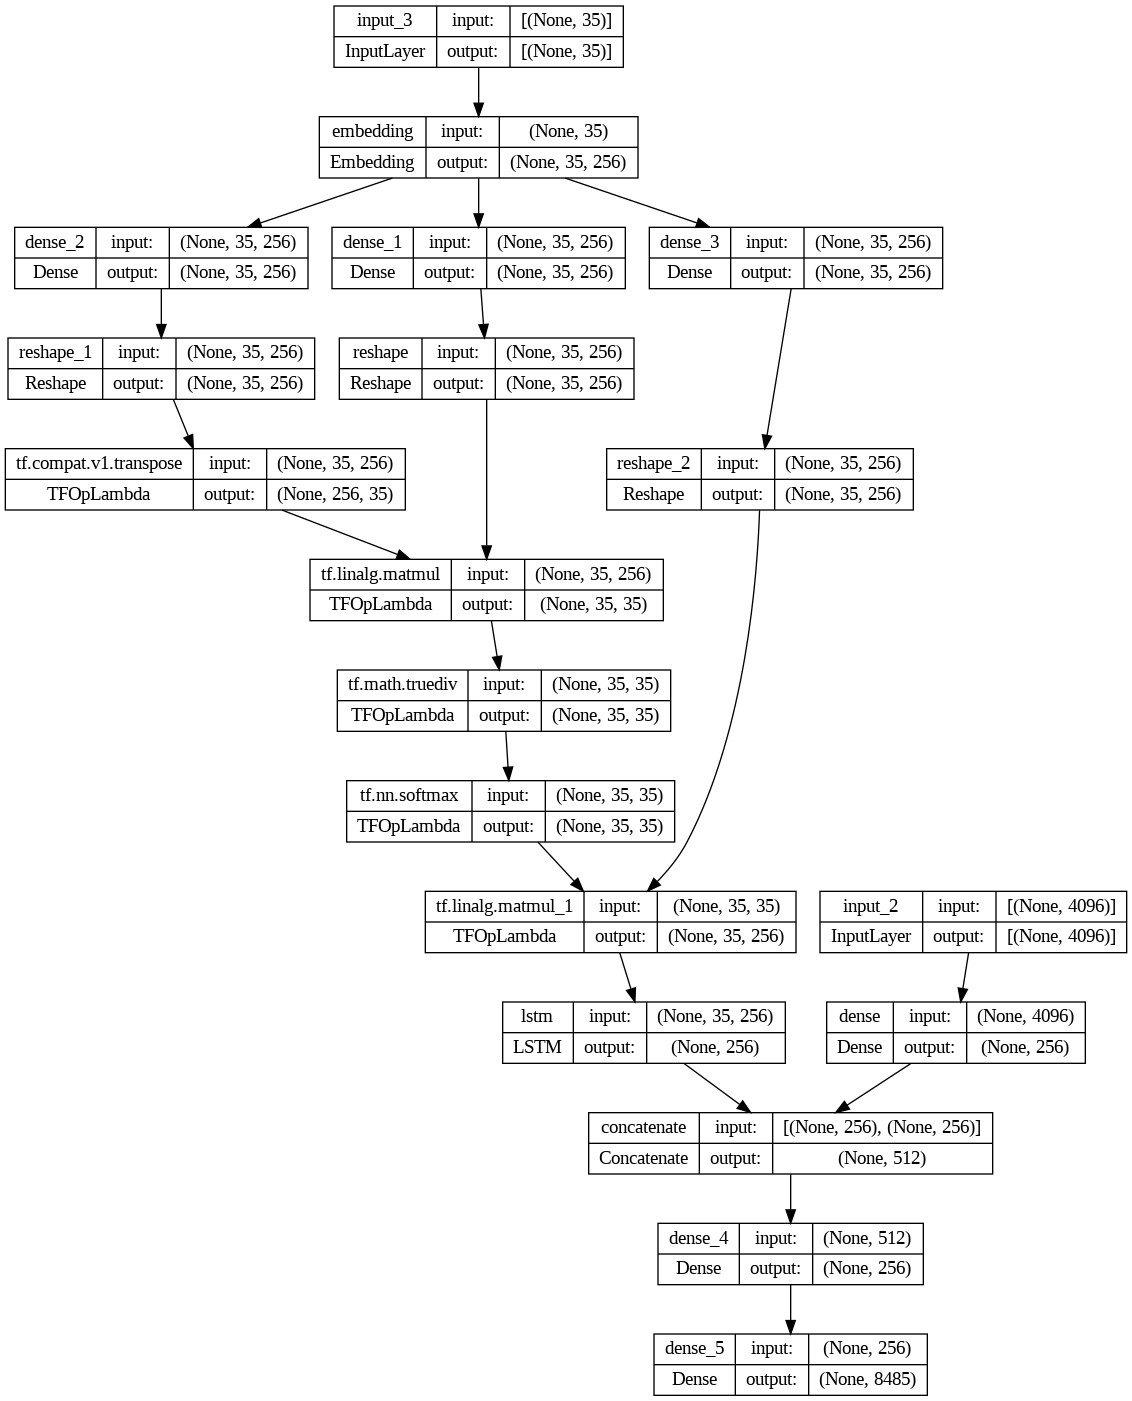

In [30]:
plot_model(model, show_shapes=True)


In [31]:
# Training
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 47s 209ms/step - loss: 2.3565


In [32]:
model.save('/content/best_model_with_self_attention.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# Generate Captions and Evaluate BLEU Score
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.523644
BLEU-2: 0.300884


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
--------------------Predicted--------------------
startseq white dog with red collar is carrying ball in its mouth endseq


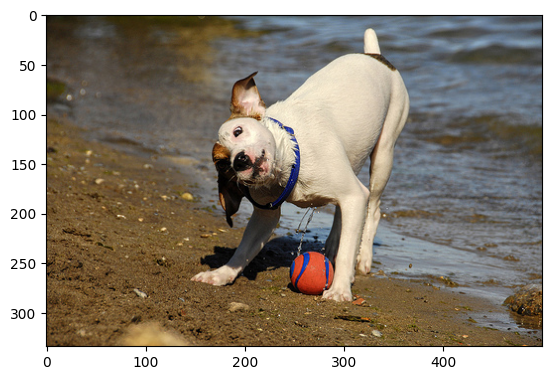

In [42]:
generate_caption("1012212859_01547e3f17.jpg")

---------------------Actual---------------------
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq
--------------------Predicted--------------------
startseq boy in swim trunks is running on the beach endseq


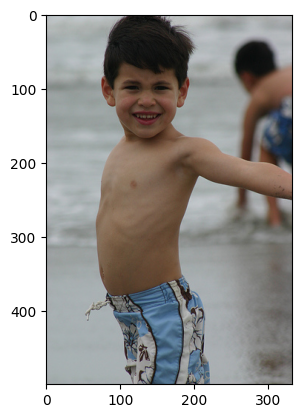

In [43]:
generate_caption("106490881_5a2dd9b7bd.jpg")

---------------------Actual---------------------
startseq people stand inside rock dome endseq
startseq shaft of light in cave shows three spelunkers endseq
startseq spelunkers pose inside rock cavern while bathed in sunlight from the surface endseq
startseq three people sit in cave endseq
startseq three rock climbers are posing on big rocks endseq
--------------------Predicted--------------------
startseq shaft of people are standing in front of mountain endseq


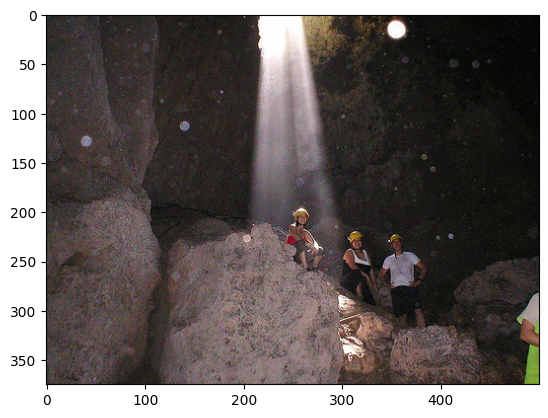

In [44]:
generate_caption("109260218_fca831f933.jpg")

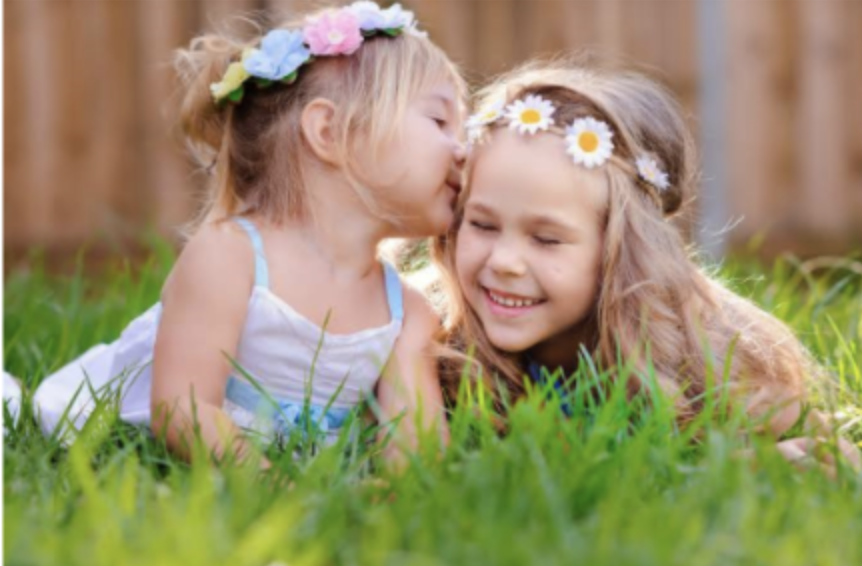

In [45]:
from IPython.display import Image, display
image_path = '/content/girls.png'
display(Image(filename=image_path))


In [46]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
image_path = '/content/girls.png'
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)
# predict
predict_caption(model, feature, tokenizer, max_length)

'startseq little girl in pink dress is standing in front of plants endseq'